# Load Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

pd.set_option("display.max_columns",None)

# Load Dataset

In [2]:
#define dataset path
movies_path="ml-latest-small/movies.csv"
ratings_path="ml-latest-small/ratings.csv"
links_path="ml-latest-small/links.csv"
tags_path="ml-latest-small/tags.csv"

movies=pd.read_csv(movies_path)
print(movies.shape)
display(movies.head())

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings=pd.read_csv(ratings_path)
print(ratings.shape)
display(ratings.head())

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
links=pd.read_csv(links_path)
print(links.shape)
display(links.head())

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
tags=pd.read_csv(tags_path)
print(tags.shape)
display(tags.head())

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
#movies_rating
movies_rating=pd.merge(movies,ratings,on="movieId")
print(movies_rating.shape)
display(movies_rating.head())

(100836, 6)


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [7]:
#check null values
display(movies_rating.isnull().sum())

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [8]:
movies_rating_count=pd.DataFrame(movies_rating.groupby('title')['rating'].count()
             .reset_index()
             .rename(columns={'title':'title','rating':'rating_count'}))
display(movies_rating_count.head())

,title,rating_count
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [9]:
#if we want to recommend movie based on rating, we want rating count 

movies_rating_combine=pd.merge(movies_rating,movies_rating_count,left_on='title',right_on='title',how='left')
print(movies_rating_combine.shape)
display(movies_rating_combine.head())

(100836, 7)


,movieId,title,genres,userId,rating,timestamp,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,215
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,215
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,215


In [10]:
display(movies_rating_combine.describe())

,movieId,userId,rating,timestamp,rating_count
count,100836.000000,100836.000000,100836.000000,1.008360e+05,100836.000000
mean,19435.295718,326.127564,3.501557,1.205946e+09,58.758777
std,35530.987199,182.618491,1.042529,2.162610e+08,61.965384
min,1.000000,1.000000,0.500000,8.281246e+08,1.000000
25%,1199.000000,177.000000,3.000000,1.019124e+09,13.000000
50%,2991.000000,325.000000,3.500000,1.186087e+09,39.000000
75%,8122.000000,477.000000,4.000000,1.435994e+09,84.000000
max,193609.000000,610.000000,5.000000,1.537799e+09,329.000000


Threshold value help us to filter the movies based on rating_count that mean we can't say that a movie with 1 rating of 5 is top movie so we need no. of ratings/rating count

<AxesSubplot:>

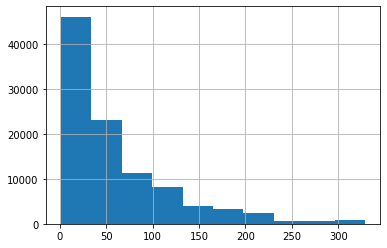

In [11]:
#plot histogram of rating_count to find threshold value
movies_rating_combine['rating_count'].hist()

#### Hence from histogram we can say that threshold value will be 50 
We won't consider that movie who's rating is 5 but by the one-two users so we will take threshold value of rating count of movies

In [12]:
rating_threshold=50

#return dataframe with rating_count>=50
movies_rating_popular=movies_rating_combine[movies_rating_combine['rating_count']>=rating_threshold]
print(movies_rating_popular.shape)

(41362, 7)


Text(0.5, 1.0, 'Top Rates Movies')

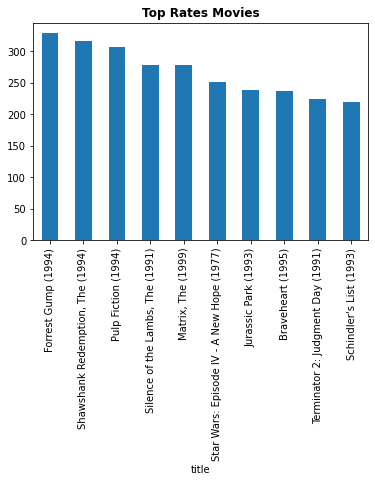

In [13]:
#top rated movies based on rating counts

movies_rating_popular.groupby('title').mean().sort_values('rating_count',ascending=False).head(10)['rating_count'].plot.bar()
plt.title("Top Rates Movies",weight='bold')

# Nearest Neighbor item based Collaborative Filtering

In [14]:
#create a Pivot matrix
movies_users_rating=movies_rating_popular.pivot_table(index='title',columns='userId',values='rating').fillna(0)
#movies_users_rating=movies_rating_popular.pivot_table(index='userId',columns='title',values='rating').fillna(0)

print(movies_users_rating.shape)
display(movies_users_rating.head())

(450, 606)


userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.

In [15]:
#from scipy.sparse import csr_matrix
#movies_users_rating_matrix=csr_matrix(movies_users_rating.values)

In [16]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(metric='cosine',algorithm='brute')
knn.fit(movies_users_rating)

NearestNeighbors(algorithm='brute', metric='cosine')

In [17]:
#define index i.e which movie I watch and based on this, more movies will be recommended
random_index=np.random.choice(movies_users_rating.shape[0])

#define movie index for next algo
recommendation_for=movies_users_rating.index[random_index]

print("{}[Index={}]".format(movies_users_rating.index[random_index],random_index))
print(recommendation_for)

Willy Wonka & the Chocolate Factory (1971)[Index=440]
Willy Wonka & the Chocolate Factory (1971)


In [18]:
#get top k recommended movies
topk=6

#return cosine distance with index of recommended movies
distance,indices=knn.kneighbors(movies_users_rating.iloc[random_index,:].values.reshape(1,-1),n_neighbors=topk+1)

#print
display(distance,indices)

array([[0.        , 0.45580527, 0.48728043, 0.48775438, 0.50558435,
        0.50723468, 0.50838307]])

array([[440, 441, 438, 408, 290, 273,  49]])

In [19]:
#movies title to be recommendated
movies_recom=[movies_users_rating.index[ind] for i,ind in enumerate(indices.flatten()[1:],1)]

In [20]:
#creating dataframe to sort the distances
recommended=pd.DataFrame({'Movie Title':movies_recom,'Score':distance.flatten()[1:]},index=indices.flatten()[1:]).sort_values('Score',ascending=False)
recommended

,Movie Title,Score
49,Beetlejuice (1988),0.508383
273,Mission: Impossible (1996),0.507235
290,"Nightmare Before Christmas, The (1993)",0.505584
408,Toy Story (1995),0.487754
438,Who Framed Roger Rabbit? (1988),0.487280
441,"Wizard of Oz, The (1939)",0.455805


# Result

In [21]:
print("Recommandations for {}:".format(movies_users_rating.index[random_index]))

for i,title in enumerate(recommended['Movie Title'].values,1):
    print("{}) {}".format(i,title))

Recommandations for Willy Wonka & the Chocolate Factory (1971):
1) Beetlejuice (1988)
2) Mission: Impossible (1996)
3) Nightmare Before Christmas, The (1993)
4) Toy Story (1995)
5) Who Framed Roger Rabbit? (1988)
6) Wizard of Oz, The (1939)


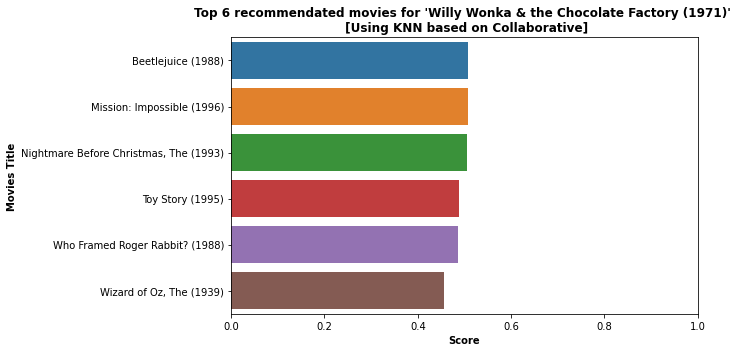

In [22]:
graph_title="Top {} recommendated movies for '{}' \n [Using KNN based on Collaborative]".format(topk,recommendation_for)

plt.figure(figsize=(10,5))

sns.barplot(x=recommended['Score'],y=recommended['Movie Title'])
plt.title(graph_title,weight='bold')
plt.xlim(0,1)
plt.xlabel("Score",weight='bold')
plt.ylabel("Movies Title",weight='bold')
plt.tight_layout()

plt.savefig(graph_title+'.jpg')
plt.show()
plt.show()

# Correlation

If a user watch above then which movies will be recommended to user?

In [23]:
movies_rating_popular.head(2)

,movieId,title,genres,userId,rating,timestamp,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,215


In [24]:
#create pivot table
#columns are title because we want to find corr of movie with other movie
users_movies_rating=movies_rating_popular.pivot_table(index='userId',columns='title',values='rating').fillna(0)

display(users_movies_rating.head())

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Air Force One (1997),Airplane! (1980),Aladdin (1992),Alien (1979),Aliens (1986),Almost Famous (2000),Amadeus (1984),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),"American President, The (1995)",American Psycho (2000),Anchorman: The Legend of Ron Burgundy (2004),Animal House (1978),Annie Hall (1977),Apocalypse Now (1979),Apollo 13 (1995),Arachnophobia (1990),Armageddon (1998),Army of Darkness (1993),As Good as It Gets (1997),Austin Powers in Goldmember (2002),Austin Powers: International Man of Mystery (1997),Austin Powers: The Spy Who Shagged Me (1999),Avatar (2009),"Avengers, The (2012)",Babe (1995),Back to the Future (1985),Back to the Future Part II (1989),Back to the Future Part III (1990),Bad Boys (1995),Batman (1989),Batman Begins (2005),Batman Forever (1995),Batman Returns (1992),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Beetlejuice (1988),Being John Malkovich (1999),Best in Show (2000),Beverly Hills Cop III (1994),Big (1988),Big Fish (2003),"Big Lebowski, The (1998)","Birdcage, The (1996)",Black Hawk Down (2001),Blade (1998),Blade Runner (1982),"Blair Witch Project, The (1999)",Blazing Saddles (1974),Blood Diamond (2006),Blow (2001),"Blues Brothers, The (1980)",Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006),"Bourne Identity, The (2002)","Bourne Supremacy, The (2004)","Bourne Ultimatum, The (2007)",Bowling for Columbine (2002),Braveheart (1995),Brazil (1985),"Breakfast Club, The (1985)",Bridget Jones's Diary (2001),Broken Arrow (1996),Bruce Almighty (2003),"Bug's Life, A (1998)",Butch Cassidy and the Sundance Kid (1969),"Cable Guy, The (1996)",Caddyshack (1980),Casablanca (1942),Casino (1995),Casino Royale (2006),Casper (1995),Cast Away (2000),Catch Me If You Can (2002),Charlie and the Chocolate Factory (2005),Charlie's Angels (2000),Chasing Amy (1997),Chicken Run (2000),Children of Men (2006),Chinatown (1974),"Christmas Story, A (1983)","Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)",Citizen Kane (1941),City Slickers II: The Legend of Curly's Gold (1994),City of God (Cidade de Deus) (2002),Clear and Present Danger (1994),Clerks (1994),"Client, The (1994)",Cliffhanger (1993),"Clockwork Orange, A (1971)",Close Encounters of the Third Kind (1977),Clueless (1995),Con Air (1997),Coneheads (1993),Congo (1995),Contact (1997),Cool Hand Luke (1967),Crash (2004),Crimson Tide (1995),Crocodile Dundee (1986),"Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)","Crow, The (1994)",Dances with Wolves (1990),"Dark Knight Rises, The (2012)","Dark Knight, The (2008)",Dave (1993),"Day After Tomorrow, The (2004)",Dead Man Walking (1995),Dead Poets Society (1989),Deadpool (2016),Demolition Man (1993),"Departed, The (2006)",Desperado (1995),Die Hard (1988),Die Hard 2 (1990),Die Hard: With a Vengeance (1995),Disclosure (1994),District 9 (2009),Django Unchained (2012),Dogma (1999),Donnie Brasco (1997),Donnie Darko (2001),Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Dragonheart (1996),Dumb & Dumber (Dumb and Dumber) (1994),E.T. the Extra-Terrestrial (1982),Ed Wood (1994),Edward Scissorhands (1990),Election (1999),Enemy of the State (1998),Eraser (1996),Erin Brockovich (2000),Eternal Sunshine of the Spotless Mind (2004),"Exorcist, The (1973)",Eyes Wide Shut (1999),Face/Off (1997),Fantasia (1940),Fargo (1996),Ferris Bueller's Day Off (1986),"Few Good Men, A (1992)",Field of Dreams (1989),"Fifth Element, The (1997)",Fight Club (1999),Finding Nemo (2003),"Firm, The (1993)",First Knight (1995),"Fish Called Wanda, A (1988)",Forrest Gump (1994),Four Wedd

In [25]:
print(recommendation_for)

Willy Wonka & the Chocolate Factory (1971)


In [26]:
#rating of above movie to find the corr of this with others
recommandation_for_rating=users_movies_rating[recommendation_for]
display(recommandation_for_rating)

userId
1      5.0
2      0.0
3      0.0
4      4.0
5      0.0
      ... 
606    0.0
607    0.0
608    3.5
609    0.0
610    0.0
Name: Willy Wonka & the Chocolate Factory (1971), Length: 606, dtype: float64

In [27]:
# corr of users rating for "given movie" with all other movies
similar_to_recommandation=users_movies_rating.corrwith(recommandation_for_rating)
similar_to_recommandation.head()

title
10 Things I Hate About You (1999)    0.182190
12 Angry Men (1957)                  0.118909
2001: A Space Odyssey (1968)         0.151752
28 Days Later (2002)                 0.159325
300 (2007)                           0.165874
dtype: float64

In [28]:
#creating a dataframe 
similar_to_recommandation=pd.DataFrame(similar_to_recommandation,columns=['Correlation'])
similar_to_recommandation.dropna(inplace=True)

display(similar_to_recommandation.head())

,Correlation
title,
10 Things I Hate About You (1999),0.182190
12 Angry Men (1957),0.118909
2001: A Space Odyssey (1968),0.151752
28 Days Later (2002),0.159325
300 (2007),0.165874


In [29]:
#sorting by Correlation to find which has highest correlation
similar_to_recommandation=similar_to_recommandation.sort_values('Correlation',ascending=False)

#first movie will not be considered because we want to recommend based on that only
display(similar_to_recommandation.head(topk+1))

,Correlation
title,
Willy Wonka & the Chocolate Factory (1971),1.000000
"Wizard of Oz, The (1939)",0.456720
Who Framed Roger Rabbit? (1988),0.415526
"Nightmare Before Christmas, The (1993)",0.396951
Mary Poppins (1964),0.394717
Beetlejuice (1988),0.394424
Grease (1978),0.394244


# Result

In [30]:
print("Recommandations for {}:".format(recommendation_for))
for i,val in enumerate(similar_to_recommandation.head(topk+1).index.values[1:],1):
    print("{}) {}".format(i,val))

Recommandations for Willy Wonka & the Chocolate Factory (1971):
1) Wizard of Oz, The (1939)
2) Who Framed Roger Rabbit? (1988)
3) Nightmare Before Christmas, The (1993)
4) Mary Poppins (1964)
5) Beetlejuice (1988)
6) Grease (1978)


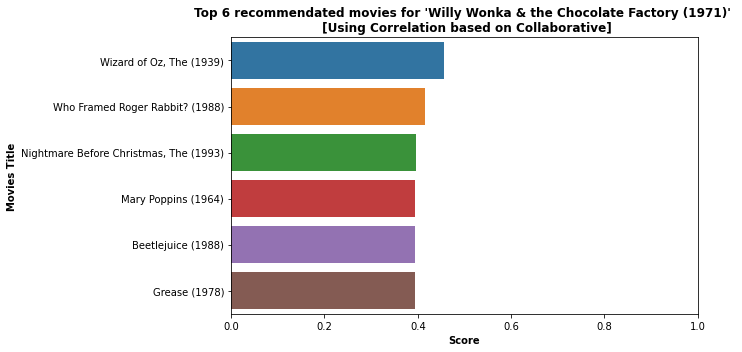

In [31]:
graph_title="Top {} recommendated movies for '{}' \n [Using Correlation based on Collaborative]".format(topk,recommendation_for)

plt.figure(figsize=(10,5))
sns.barplot(x=similar_to_recommandation['Correlation'].iloc[1:topk+1],y=similar_to_recommandation.index[1:topk+1])
plt.title(graph_title,weight='bold')
plt.xlim(0,1)
plt.xlabel("Score",weight='bold')
plt.ylabel("Movies Title",weight='bold')

plt.tight_layout()
plt.savefig(graph_title+'.jpg')
plt.show()

